# The Type of Player Contributes The Most Data To The PLAICraft Research

## Introduction To Our Project

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
options(repr.plot.width = 8, repr.plot.height = 7)

players_wrangled <- players |>
                        select(- hashedEmail, - individualId, - organizationName) |>
                        group_by(experience) |>
                        filter(played_hours >= 0.1)

## Methods and Results

In [4]:
set.seed(1)

players_experience <- players_wrangled |>
    select(experience, age, played_hours) # Dataframe for Experience Classification

experience_split <- initial_split(players_experience, prop = 0.75, strata = experience) 
# Creates a 25/75 split into training data and validation data
experience_train <- training(experience_split)
experience_test <- testing(experience_split)

# experience_split <- initial_split(players_experience, prop = 0.75, strata = experience) 
# # Creates a 25/75 split into training data and validation data
# experience_subtrain <- training(experience_split)
# experience_test <- testing(experience_split)

# knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#   set_engine("kknn") |>
#   set_mode("classification")

# exp_training_recipe <- recipe(experience ~ age + played_hours, data = experience_train) |>
#     step_scale(all_predictors()) |>
#     step_center(all_predictors())

# exp_workflow <- workflow() |>
#     add_recipe(exp_training_recipe) |>
#     add_model(knn_spec) |>
#     fit(data = experience_subtrain)

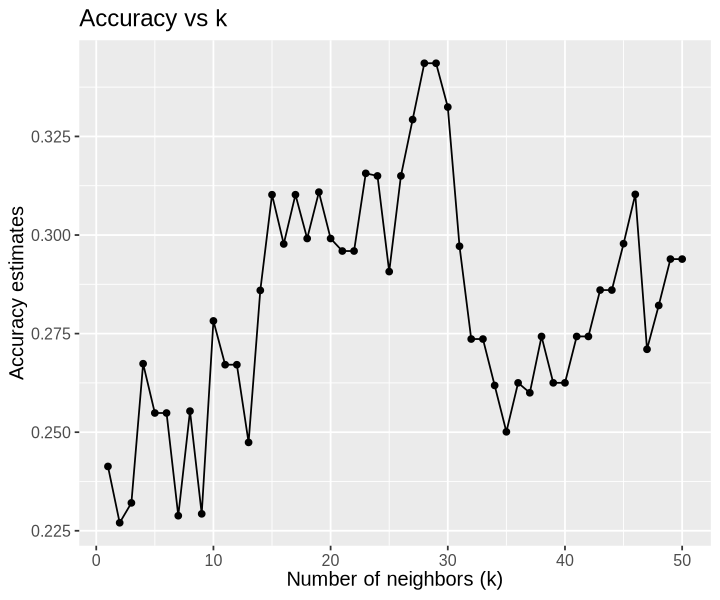

In [5]:
options(repr.plot.height = 5, repr.plot.width = 6)

# your code here
cross_recipe <- recipe(experience ~ age + played_hours, data = experience_train)

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
                                set_engine("kknn") |>
                                set_mode("classification")

cross_folds <- vfold_cv(experience_train, v = 5, strata = experience)

cross_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

cross_prediction <- workflow() |>
                    add_recipe(cross_recipe) |>
                    add_model(knn_spec) |>
                    tune_grid(resamples = cross_folds, grid = cross_vals) |>
                    collect_metrics()

accuracies <- cross_prediction |>
                filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(title = "Accuracy vs k", x = "Number of neighbors (k)",
                         y = "Accuracy estimates") +
                    theme(text = element_text(size = 12))

cross_val_plot

In [12]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 29) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
                add_recipe(cross_recipe) |>
                add_model(knn_spec) |>
                fit(data = experience_train)

In [18]:
exp_test_predictions <- predict(knn_fit, experience_test) |>
  bind_cols(experience_test)

exp_test_predictions

.pred_class,experience,age,played_hours
<fct>,<chr>,<dbl>,<dbl>
Veteran,Regular,19,0.6
Amateur,Regular,8,0.3
Veteran,Amateur,21,0.7
Veteran,Veteran,20,0.4
Veteran,Amateur,17,0.2
Amateur,Veteran,24,2.2
Veteran,Beginner,22,0.4
Veteran,Amateur,18,0.9
Veteran,Veteran,21,0.1


In [ ]:
# experience_vfold <- vfold_cv(experience_train, v = 5, strata = experience)
# experience_vfold

In [ ]:
# option

# experience_recipe <- recipe(experience ~ age + played_hours, data = experience_train) |>
#     step_scale(all_predictors()) |>
#     step_center(all_predictors()) |>
#     prep()

# scaled_experience <- bake(experience_recipe, players_experience)

# scaled_plot <- scaled_experience |>
#     ggplot(aes(x = age, y = played_hours, color = experience)) +
#     geom_point(alpha = 0.6) +
#     labs(x = 'Age (Standardized)', y = 'Hours Played (Standardized)', color = 'Experience')
# scaled_plot

In [ ]:
# exp_recipe <- recipe(experience ~ age + played_hours, data = experience_train) |>
#     step_scale(all_predictors()) |>
#     step_center(all_predictors())

# knn_fit <- workflow() |>
#   add_recipe(exp_recipe) |>
#   add_model(knn_spec) |>
#   fit(data = players_experience)
# knn_fit
# new_observation <- tibble(age = c(100,23), played_hours = c(99, 111))
# prediction <- predict(knn_fit, new_observation)

# prediction